In [61]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [62]:
def fetch_dota2_matches_less_than(less_than_match_id, limit=100):
    """
    Fetch matches using less_than_match_id from the OpenDota API.
    """
    url = f"https://api.opendota.com/api/proMatches?less_than_match_id={less_than_match_id}&limit={limit}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch matches: {response.status_code}")
        return []

In [68]:
def fetch_dota2_matches_until(target_count=5000, initial_match_id=8063200834, batch_size=100):
    """
    Fetch matches iteratively until the target number of matches is reached.
    """
    all_matches = []
    current_match_id = initial_match_id

    while len(all_matches) < target_count:
        batch = fetch_dota2_matches_less_than(current_match_id, limit=batch_size)
        if not batch:
            break
        all_matches.extend(batch)
        current_match_id = min(match['match_id'] for match in batch)  # Update to fetch older matches
        print(f"Collected {len(all_matches)} matches so far...")

    return all_matches[:target_count]  # Return the target number of matches


In [69]:
matches = fetch_dota2_matches_until(target_count=5000, initial_match_id=8063200834)

Collected 100 matches so far...
Collected 200 matches so far...
Collected 300 matches so far...
Collected 400 matches so far...
Collected 500 matches so far...
Collected 600 matches so far...
Collected 700 matches so far...
Collected 800 matches so far...
Collected 900 matches so far...
Collected 1000 matches so far...
Collected 1100 matches so far...
Collected 1200 matches so far...
Collected 1300 matches so far...
Collected 1400 matches so far...
Collected 1500 matches so far...
Collected 1600 matches so far...
Collected 1700 matches so far...
Collected 1800 matches so far...
Collected 1900 matches so far...
Collected 2000 matches so far...
Collected 2100 matches so far...
Collected 2200 matches so far...
Collected 2300 matches so far...
Collected 2400 matches so far...
Collected 2500 matches so far...
Collected 2600 matches so far...
Collected 2700 matches so far...
Collected 2800 matches so far...
Collected 2900 matches so far...
Collected 3000 matches so far...
Collected 3100 matc

In [70]:
matches

[{'match_id': 8063176161,
  'duration': 1826,
  'start_time': 1733079671,
  'radiant_team_id': 9381678,
  'radiant_name': 'Apex Genesis',
  'dire_team_id': 8697185,
  'dire_name': 'Fantasy Gaming',
  'leagueid': 17367,
  'league_name': 'EPL World Series: America 2024-2025 Season ',
  'series_id': 931242,
  'series_type': 1,
  'radiant_score': 19,
  'dire_score': 34,
  'radiant_win': False,
  'version': 21},
 {'match_id': 8063086548,
  'duration': 2002,
  'start_time': 1733076235,
  'radiant_team_id': 8697185,
  'radiant_name': 'Fantasy Gaming',
  'dire_team_id': 9381678,
  'dire_name': 'Apex Genesis',
  'leagueid': 17367,
  'league_name': 'EPL World Series: America 2024-2025 Season ',
  'series_id': 931242,
  'series_type': 1,
  'radiant_score': 13,
  'dire_score': 47,
  'radiant_win': False,
  'version': 21},
 {'match_id': 8063069899,
  'duration': 3367,
  'start_time': 1733076211,
  'radiant_team_id': 8291895,
  'radiant_name': 'Tundra Esports',
  'dire_team_id': 8255888,
  'dire_nam

In [74]:
def preprocess_matches(matches):
    """
    Preprocess matches into a DataFrame with relevant features for Radiant and Dire teams.
    """
    records = []
    for match in matches:
        try:
            # Extract match outcome and team features
            radiant_win = int(match['radiant_win'])  # Binary outcome
            radiant_gold = match.get('radiant_gold', 0)
            dire_gold = match.get('dire_gold', 0)
            radiant_xp = match.get('radiant_xp', 0) 
            dire_xp = match.get('dire_xp', 0)
            radiant_heroes = match.get('radiant_team', [0] * 5)
            dire_heroes = match.get('dire_team', [0] * 5)

            # Create a record for each match
            records.append({
                "radiant_win": radiant_win,  # Binary outcome
                "radiant_gold": radiant_gold,
                "dire_gold": dire_gold,
                "radiant_xp": radiant_xp,
                "dire_xp": dire_xp,
                **{f"radiant_hero_{i}": radiant_heroes[i] if i < len(radiant_heroes) else 0 for i in range(5)},
                **{f"dire_hero_{i}": dire_heroes[i] if i < len(dire_heroes) else 0 for i in range(5)},
            })
        except KeyError:
            # Skip matches with missing data
            continue
    return pd.DataFrame(records)

In [72]:
df = preprocess_matches(matches)

In [55]:
df = pd.get_dummies(df, columns=[f"radiant_hero_{i}" for i in range(5)] + [f"dire_hero_{i}" for i in range(5)])


In [73]:
df

,radiant_win,radiant_gold,dire_gold,radiant_xp,dire_xp,radiant_hero_0,radiant_hero_1,radiant_hero_2,radiant_hero_3,radiant_hero_4,dire_hero_0,dire_hero_1,dire_hero_2,dire_hero_3,dire_hero_4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
X = df.drop(columns=["radiant_win"])
y = df["radiant_win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [58]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       499
           1       0.50      1.00      0.67       501

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



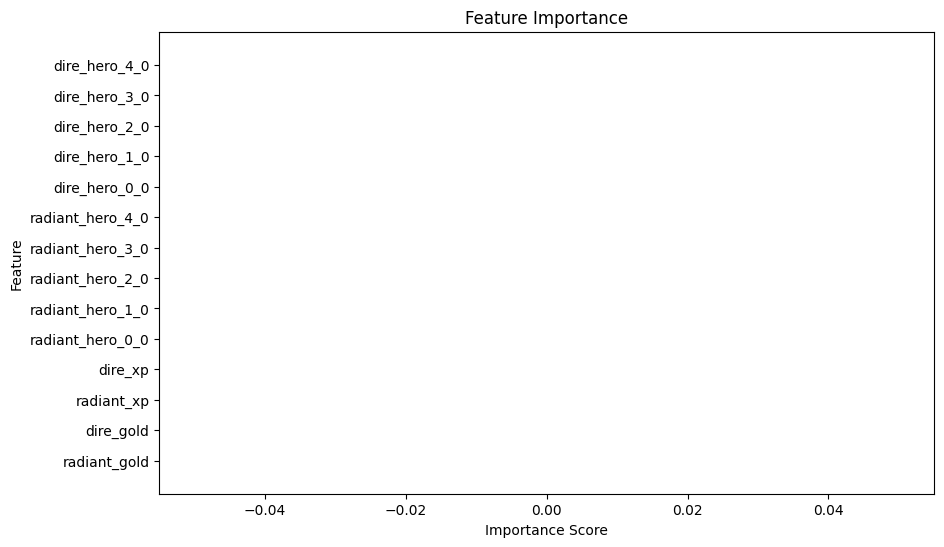

In [59]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()